In [438]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.interpolate import interp1d
import scipy
import pandas as pd
%matplotlib inline

In [439]:
class _ListDict_(object):
    
    def __init__(self):
        self.item_to_position = {}
        self.items = []

    def __len__(self):
        return len(self.items)

    def add(self, item):
        if item in self.item_to_position:
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove(self, item):
        if item in self.item_to_position:
            position = self.item_to_position.pop(item)
            del self.items[position]
            for i in range(len(self.items)):
                if i >= position:
                    self.item_to_position[self.items[i]] = self.item_to_position[self.items[i]] - 1
        
        #last_item = self.items.pop()
        #if position != len(self.items):
        #    self.items[position] = last_item
        #    self.item_to_position[last_item] = position

    def choose_random(self):
        return random.choice(self.items)
    
    def __repr__(self):
         return repr(self.items)

    def __str__(self):
         return str(self.items)

In [588]:
def initialize_SIS_(G, initial_infecteds, infection_times, recovery_times, tmin):
    times = [tmin]
    S = [G.order()-len(initial_infecteds)]
    I = [len(initial_infecteds)]
    status = defaultdict(lambda:'S') #by default all are susceptible
    infected = list(initial_infecteds)
    infected_neighbor_count = defaultdict(lambda:0)
    risk_group = defaultdict(lambda:_ListDict_()) 
    
    for node in initial_infecteds:
        status[node] = 'I'
    for node in initial_infecteds:
        for neighbor in G.neighbors(node):
            if status[neighbor] == 'S':
                infected_neighbor_count[neighbor] += 1
                if infected_neighbor_count[neighbor] > 1:
                    risk_group[infected_neighbor_count[neighbor]-1].remove(
                                                                    neighbor)
                        
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)

    return times, S, I, status, infected, infected_neighbor_count, risk_group

In [635]:
def infect(G, S, I, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    
    for n in risk_group.keys():
        r -= n*len(risk_group[n])
        if r < 0:
            break

    recipient = risk_group[n].choose_random()
    
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient] = 'I'
    S.append(S[-1] - 1)
    I.append(I[-1] + 1)
    times.append(current_time)

    for neighbor in G.neighbors(recipient):
        if status[neighbor] == 'S':
            if infected_neighbor_count[neighbor] > 0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] += 1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)

In [590]:
def recover(G, S, I, times, infected, current_time, status, 
            infected_neighbor_count, risk_group, recovery_times):
    
    index = random.randint(0, I[-1] - 1)
    infected[index], infected[-1] = infected[-1], infected[index]
    recovering_node = infected.pop()

    I.append(I[-1] - 1)
    status[recovering_node] = 'S'
    S.append(S[-1] + 1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else:
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(recovering_node)

In [591]:
def SIS(G, tau, gamma, initial_infecteds = None, rho = None, tmin = 0, tmax = 100):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS_(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            infect(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
            #updates variables as needed and calculates new max_trans_rate
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')
        

    return scipy.array(times), scipy.array(S), scipy.array(I)

In [444]:
def SIS_detailed(G, tau, gamma, initial_infecteds = None, tmax = 100, answer = None):

    infection_times = defaultdict(lambda: [])
    recovery_times = defaultdict(lambda: [])

    tau = float(tau)
    gamma = float(gamma)
    
    tmin = 0
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin)
    
    print("After initialization")
    print("times: ", times)
    print("S: ", S)
    print("I: ", I)
    print("Status: ", status)
    print("infected: ", infected)
    print("risk_group: ", risk_group)

    total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    
    inf_array = []
    inf_array.append(infected[:])
    
    while next_time < tmax and infected:
        r = random.random()*total_rate
        
        if r < total_rec_rate:
            print("recover")
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times)
            total_rec_rate = gamma*I[-1]
        else:
            print("infection")
            infect(G, S, I, times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times)
            #updates variables as needed and calculates new max_trans_rate
        
        print("infected: ", infected)
        print("risk_group: ", risk_group)
        
        total_trans_rate = tau*sum(n*len(risk_group[n]) for n in risk_group.keys())
        print("total_trans_rate: ", total_trans_rate)
        total_rate = total_rec_rate + total_trans_rate
        print("total_rate: ", total_rate)
        
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')
            
        inf_array.append(infected[:])
        print('-----------------------')
        

    return scipy.array(times), scipy.array(S), scipy.array(I), inf_array

After initialization
times:  [0]
S:  [5016]
I:  [3]
Status:  defaultdict(<function initialize_SIS.<locals>.<lambda> at 0x1819ae2840>, {'CREAM': 'I', 'SKATE': 'I', 'WATER': 'I', 'CHEESE': 'S', 'COFFEE': 'S', 'ICE': 'S', 'MILK': 'S', 'RICH': 'S', 'SHAVE': 'S', 'SMOOTH': 'S', 'SODA': 'S', 'STRAWBERRY': 'S', 'SUGAR': 'S', 'SWEET': 'S', 'THICK': 'S', 'WHIP': 'S', 'WHITE': 'S', 'BOARD': 'S', 'FALL': 'S', 'GLIDE': 'S', 'RAT': 'S', 'RIDE': 'S', 'ROLL': 'S', 'SKI': 'S', 'SLIDE': 'S', 'SPEED': 'S', 'AIR': 'S', 'COLD': 'S', 'COOL': 'S', 'COOLER': 'S', 'DRINK': 'S', 'FAUCET': 'S', 'JUG': 'S', 'LAKE': 'S', 'LIQUID': 'S', 'OCEAN': 'S', 'POOL': 'S', 'SEA': 'S', 'SWIM': 'S', 'THIRST': 'S', 'THIRSTY': 'S', 'WELL': 'S', 'WET': 'S'})
infected:  ['CREAM', 'SKATE', 'WATER']
risk_group:  defaultdict(<function initialize_SIS.<locals>.<lambda> at 0x1819ae2510>, {1: ['CHEESE', 'COFFEE', 'MILK', 'RICH', 'SHAVE', 'SMOOTH', 'SODA', 'STRAWBERRY', 'SUGAR', 'SWEET', 'THICK', 'WHIP', 'WHITE', 'BOARD', 'FALL', 'GLIDE'

risk_group:  defaultdict(<function initialize_SIS.<locals>.<lambda> at 0x1819ae2510>, {1: ['OCEAN', 'BRAND', 'CLEAN', 'FRESH', 'RECENT', 'SHINE', 'UNUSED', 'USED', 'ANCIENT', 'HOUSE', 'WISE', 'YOUNG', 'AUTO', 'BICYCLE', 'BOAT', 'BUS', 'DRIVE', 'ENGINE', 'EXPENSIVE', 'FAST', 'GAS', 'MONEY', 'PLANE', 'RACE', 'RIDE', 'ROAD', 'SPEED', 'STREET', 'TIRE', 'TRAIN', 'TRANSPORTATION', 'TRAVEL', 'TRUCK', 'WHEEL', 'BELL', 'BONDAGE', 'COUNTRY', 'DEMOCRACY', 'FLAG', 'FOREVER', 'FREE', 'HAPPINESS', 'INDEPENDENT', 'JUSTICE', 'LIBERTY', 'PEACE', 'ROCK', 'SPEECH', 'USA', 'YES', 'AWESOME', 'AWFUL', 'BAD', 'BEST', 'BIG', 'HUGE', 'LARGE', 'LITTLE', 'POOR', 'SMALL', 'SUPER', 'TERRIBLE', 'TERRIFIC', 'WONDERFUL', 'BEND', 'CREASE', 'FACE', 'FOLD', 'IRON', 'LINE', 'SKIN', 'SMOOTH', 'STRAIGHT'], 2: ['MAN', 'AGE'], 3: [], 0: ['FIGHTER', 'GOOD'], 4: [], -1: ['GOOD']})
total_trans_rate:  3.8000000000000003
total_rate:  5.800000000000001
-----------------------
recover
infected:  ['OLD', 'NEW', 'WRINKLE', 'FREEDOM',

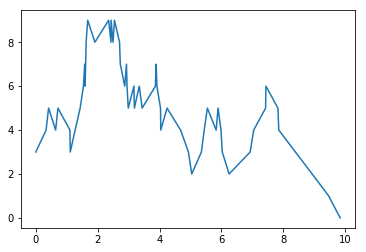

In [691]:
init_inf = ['CREAM', 'SKATE', 'WATER']
gamma = 1.
tau = 0.05
t, S, I, inf_array = SIS_detailed(G, tau, gamma, tmax = 20, initial_infecteds = init_inf, answer = 'ICE')
for i in inf_array:
    print(i)
plt.plot(t, I)

In [692]:
inf_array

[['CREAM', 'SKATE', 'WATER'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY', 'WET'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY', 'DRINK'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'STRAWBERRY', 'WATER'],
 ['CREAM', 'STRAWBERRY', 'WATER', 'ICE'],
 ['CREAM', 'STRAWBERRY', 'WATER', 'ICE', 'GOOD'],
 ['CREAM', 'STRAWBERRY', 'WATER', 'ICE', 'GOOD', 'FAUCET'],
 ['CREAM', 'STRAWBERRY', 'WATER', 'ICE', 'GOOD', 'FAUCET', 'OCEAN'],
 ['CREAM', 'OCEAN', 'WATER', 'ICE', 'GOOD', 'FAUCET'],
 ['CREAM', 'OCEAN', 'WATER', 'ICE', 'GOOD', 'FAUCET', 'NICE'],
 ['CREAM', 'OCEAN', 'WATER', 'ICE', 'GOOD', 'FAUCET', 'NICE', 'DEEP'],
 ['CREAM', 'OCEAN', 'WATER', 'ICE', 'GOOD', 'FAUCET', 'NICE', 'DEEP', 'WELL'],
 ['CREAM', 'OCEAN', 'WATER', 'ICE', 'GOOD', 'FAUCET', 'NICE', 'DEEP'],
 ['CREAM', 'OCEAN', 'WATER', 'ICE', 'GOOD', 'FAUCET', 'NICE', 'DEEP', 'WELL'],
 ['CREAM', 'OCEAN', 'WATER', 'ICE', 'GOOD', 'WELL', 'NICE', 

In [694]:
inf_array[:8]

[['CREAM', 'SKATE', 'WATER'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY', 'WET'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY', 'DRINK'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'STRAWBERRY', 'WATER'],
 ['CREAM', 'STRAWBERRY', 'WATER', 'ICE']]

In [695]:
inf_set = set([item for sublist in inf_array[:8] for item in sublist])

In [696]:
inf_set_with_neighbors = set()
for i in range(len(list(inf_set))):
    count = 0
    for word in G.neighbors(list(inf_set)[i]):
        if count < 5:
            inf_set_with_neighbors.add(word)
            count +=1
        else:
            break
for word in init_inf:
    inf_set_with_neighbors.add(word)
for arr in inf_array[:10]:
    for elem in arr:
        inf_set_with_neighbors.add(elem)

(-1.2099999744436658,
 1.209999988627217,
 -1.2099999662754757,
 1.2099999967954072)

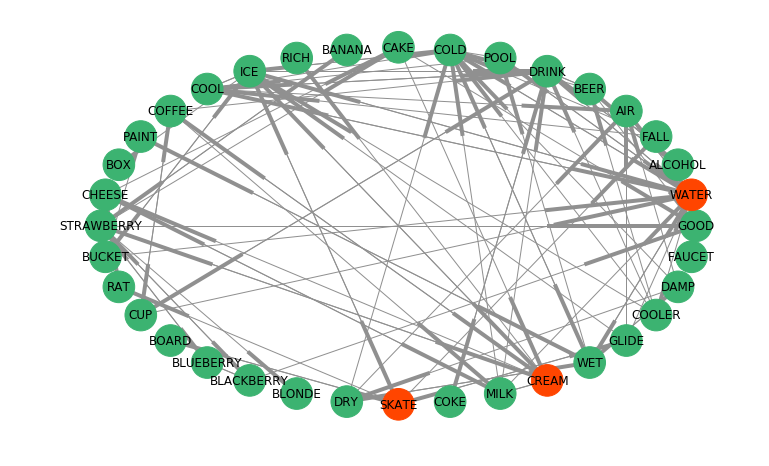

In [697]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set_with_neighbors))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(10,6))

color_map = []
for node in GG:
    if node in init_inf:
        color_map.append('orangered')
    else: color_map.append('mediumseagreen') 
        
nx.draw_circular(GG, node_color=color_map, edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

In [639]:
inf_array

[['CREAM', 'SKATE', 'WATER'],
 ['WATER', 'SKATE'],
 ['WATER', 'SKATE', 'COOL'],
 ['WATER', 'SKATE', 'COOL', 'SKI'],
 ['SKI', 'SKATE', 'COOL'],
 ['SKI', 'SKATE'],
 ['SKATE'],
 ['SKATE', 'SPEED'],
 ['SKATE', 'SPEED', 'VELOCITY'],
 ['VELOCITY', 'SPEED'],
 ['VELOCITY', 'SPEED', 'WIND'],
 ['VELOCITY', 'SPEED', 'WIND', 'HIGH'],
 ['VELOCITY', 'SPEED', 'HIGH'],
 ['VELOCITY', 'SPEED', 'HIGH', 'DEMON'],
 ['VELOCITY', 'SPEED', 'HIGH', 'DEMON', 'MATH'],
 ['VELOCITY', 'SPEED', 'HIGH', 'DEMON', 'MATH', 'TICKET'],
 ['VELOCITY', 'SPEED', 'HIGH', 'DEMON', 'MATH', 'TICKET', 'YUCK'],
 ['VELOCITY', 'SPEED', 'HIGH', 'DEMON', 'MATH', 'TICKET', 'YUCK', 'FIGURE'],
 ['VELOCITY', 'SPEED', 'HIGH', 'DEMON', 'MATH', 'TICKET', 'FIGURE'],
 ['VELOCITY', 'SPEED', 'HIGH', 'DEMON', 'FIGURE', 'TICKET'],
 ['VELOCITY', 'SPEED', 'TICKET', 'DEMON', 'FIGURE'],
 ['VELOCITY', 'SPEED', 'TICKET', 'DEMON'],
 ['VELOCITY', 'DEMON', 'TICKET'],
 ['VELOCITY', 'TICKET'],
 ['VELOCITY', 'TICKET', 'RIDE'],
 ['VELOCITY', 'TICKET', 'RIDE', '

In [698]:
inf_array[:8]

[['CREAM', 'SKATE', 'WATER'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY', 'WET'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY', 'DRINK'],
 ['CREAM', 'SKATE', 'WATER', 'STRAWBERRY'],
 ['CREAM', 'STRAWBERRY', 'WATER'],
 ['CREAM', 'STRAWBERRY', 'WATER', 'ICE']]

(-1.2099999744436658,
 1.209999988627217,
 -1.2099999662754757,
 1.2099999967954072)

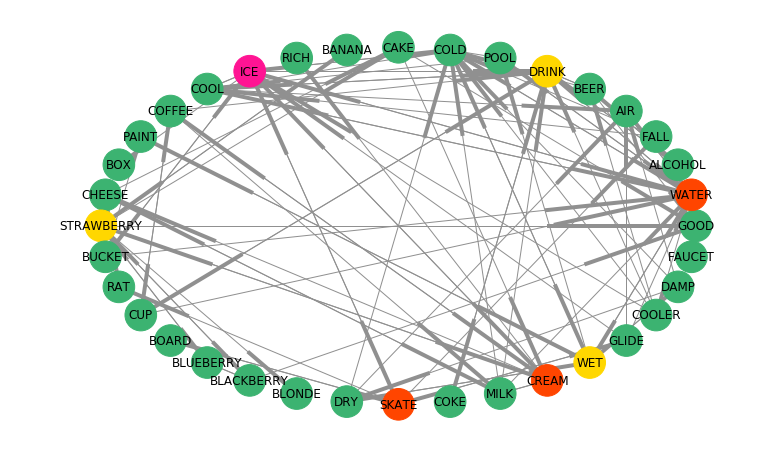

In [703]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set_with_neighbors))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(10,6))

color_map = []
for node in GG:
    if node in ['WATER', 'CREAM', 'SKATE']:
        color_map.append('orangered')
    elif node in ['STRAWBERRY', 'WET', 'DRINK']:
        color_map.append('gold')
    elif node in ['ICE']:
        color_map.append('deeppink')
    else: color_map.append('mediumseagreen')
        
nx.draw_circular(GG, node_color=color_map, edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

(-1.2070521593819699,
 1.2097198884480604,
 -1.2091927293799443,
 1.209192751211878)

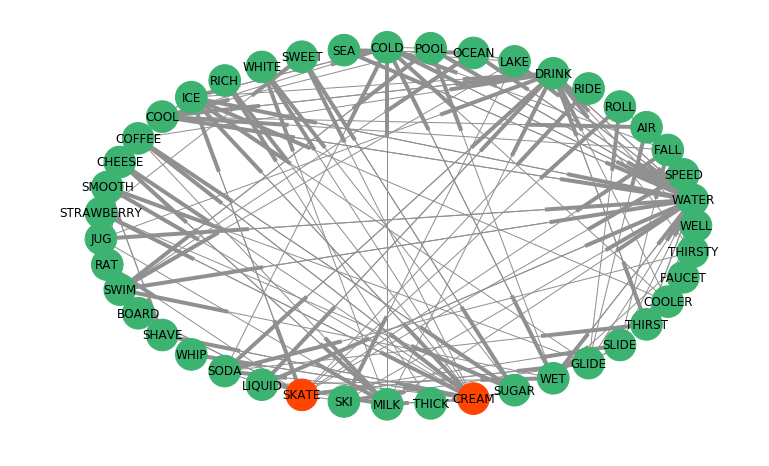

In [405]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set_with_neighbors))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(10,6))

color_map = []
for node in GG:
    if node in inf_array[1]:
        color_map.append('orangered')
    else: color_map.append('mediumseagreen') 
        
nx.draw_circular(GG, node_color=color_map, edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

(-0.030808588527143008,
 1.0109620634838938,
 -0.10091570053482429,
 1.088349616259802)

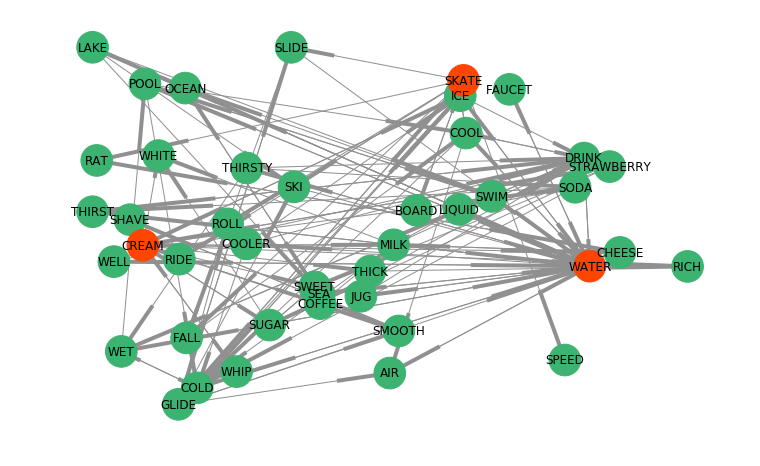

In [437]:
GG=nx.DiGraph()
H = G.subgraph(list(inf_set_with_neighbors))
GG.add_nodes_from(H.nodes)
GG.add_edges_from(H.edges)

labels = {}
for node in H.nodes():
    labels[node] = node
plt.figure(1, figsize=(10,6))

color_map = []
for node in GG:
    if node in inf_array[0]:
        color_map.append('orangered')
    else: color_map.append('mediumseagreen') 
        
nx.draw_random(GG, node_color=color_map, edge_color='#909090', node_size=1000, labels=labels)

plt.axis('off')

In [427]:
inf_array

[['CREAM', 'SKATE', 'WATER'],
 ['CREAM', 'SKATE'],
 ['CREAM', 'SKATE', 'SMOOTH'],
 ['CREAM', 'SKATE', 'SMOOTH', 'SLIDE'],
 ['CREAM', 'SKATE', 'SMOOTH', 'SLIDE', 'COFFEE'],
 ['CREAM', 'SKATE', 'SMOOTH', 'SLIDE', 'COFFEE', 'CAFFEINE'],
 ['CREAM', 'SKATE', 'SMOOTH', 'SLIDE', 'COFFEE'],
 ['CREAM', 'COFFEE', 'SMOOTH', 'SLIDE'],
 ['CREAM', 'COFFEE', 'SMOOTH'],
 ['CREAM', 'COFFEE'],
 ['CREAM'],
 ['CREAM', 'COFFEE'],
 ['CREAM', 'COFFEE', 'RICH'],
 ['CREAM', 'COFFEE', 'RICH', 'LUCK'],
 ['CREAM', 'COFFEE', 'RICH', 'LUCK', 'BLACK'],
 ['BLACK', 'COFFEE', 'RICH', 'LUCK'],
 ['LUCK', 'COFFEE', 'RICH'],
 ['LUCK', 'COFFEE'],
 ['LUCK'],
 []]

In [631]:
df = pd.read_excel('assoc_eng.xlsx')
G = nx.from_pandas_dataframe(df, 'Source', 'Target', edge_attr=None, create_using=nx.DiGraph())

## Пример 1

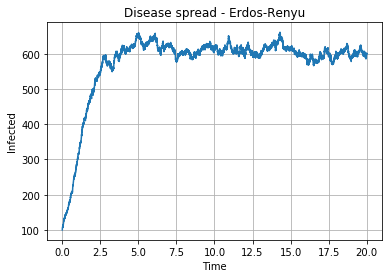

In [58]:
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.05
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))

plt.title('Disease spread - Erdos-Renyu')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.grid(True)

plt.plot(t, I)

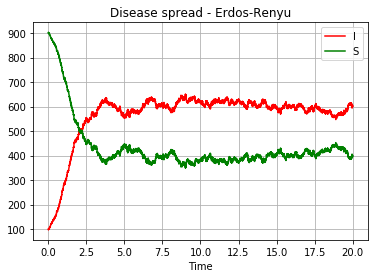

In [610]:
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.05
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
fig, ax = plt.subplots()
plt.title('Disease spread - Erdos-Renyu')
ax.set_xlabel('Time')
ax.grid(True)

ax.plot(t, I, label = 'I', c = 'red')
ax.plot(t, S, label = 'S', c = 'green')
plt.legend()
plt.show()

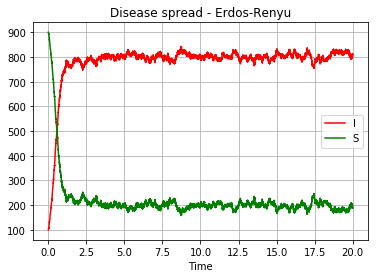

In [611]:
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.1
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
fig, ax = plt.subplots()
plt.title('Disease spread - Erdos-Renyu')
ax.set_xlabel('Time')
ax.grid(True)

ax.plot(t, I, label = 'I', c = 'red')
ax.plot(t, S, label = 'S', c = 'green')
plt.legend()
plt.show()

In [7]:
def get_stability_time(inf_arr, num_steps, interval, eps, threshold):
    count = 0
    stab_time = num_steps
    for i, j in zip(np.arange(0, num_steps - interval, 1), np.arange(interval, num_steps, 1)):
        if abs(inf_arr[j] - inf_arr[i]) < eps:
            count += 1
        else:
            count = 0
        if count > threshold:
            stab_time = i
            break
    return stab_time        

In [108]:
stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
t[stab_time - 1]

2.8424202300647026

## Пример 2

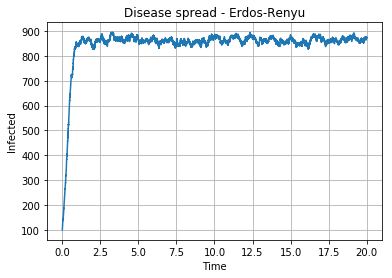

In [59]:
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.15
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))

plt.title('Disease spread - Erdos-Renyu')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.grid(True)

plt.plot(t, I)

In [112]:
stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
t[stab_time - 1]

1.2863774773504808

## Ансабль из 100 сетей

In [577]:
network_arr = np.arange(100)
N = 1000
p = 0.05
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.erdos_renyi_graph(N, p))

### Построим зависимость времени стабилизации от вероятности заражения

In [578]:
p_inf_arr = np.linspace(0.01, 0.2, 20)
p_inf_arr

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [592]:
initial_size = 100
gamma = 1.
t_stab = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    stab_time_arr = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
        stab_time_arr.append(t[stab_time - 1])
    
    t_stab.append(np.mean(stab_time_arr))
    std_arr.append(np.std(stab_time_arr))

--------------------------------
infection probability:  0.01
--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.03
--------------------------------
infection probability:  0.04
--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.060000000000000005
--------------------------------
infection probability:  0.06999999999999999
--------------------------------
infection probability:  0.08
--------------------------------
infection probability:  0.09
--------------------------------
infection probability:  0.09999999999999999
--------------------------------
infection probability:  0.11
--------------------------------
infection probability:  0.12
--------------------------------
infection probability:  0.13
--------------------------------
infection probability:  0.14
--------------------------------
infection probability:  0.15000000000000002
---------

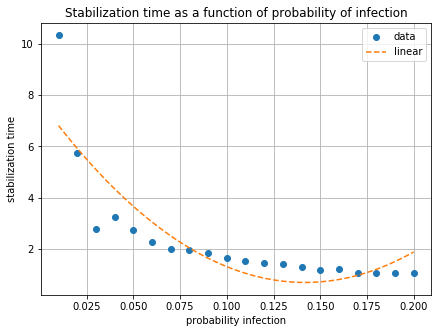

In [594]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 2))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.01, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p30(xp), '--')#, xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'quadratic', 'cubic'], loc='best')
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.grid(True)
plt.show()

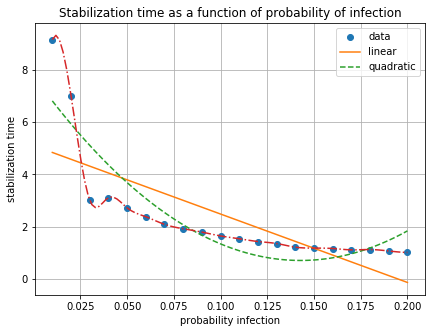

In [15]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 2))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.01, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p(xp), '-', xp, p30(xp), '--', xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'quadratic'], loc='best')
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.grid(True)
plt.show()

In [15]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')

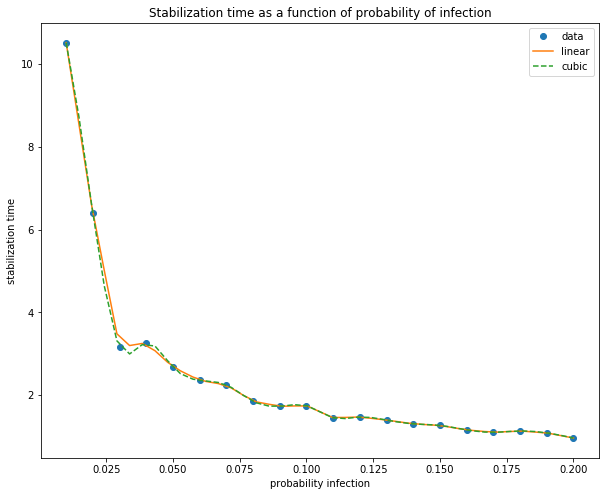

In [16]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.01, 0.2, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0,0.5,'stabilization time')

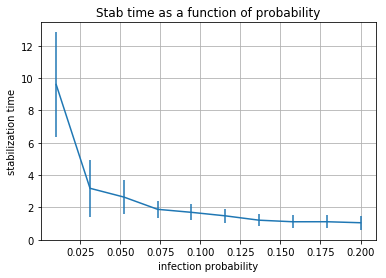

In [38]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, t_stab, yerr = std_arr)
ax.grid(True)
ax.set_title('Stab time as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('stabilization time')

### Зависимость доли зараженных в момент стабилизации от вероятности заражения

In [595]:
p_inf_arr = np.linspace(0.002, 0.2, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.002
--------------------------------
infection probability:  0.012421052631578947
--------------------------------
infection probability:  0.022842105263157893
--------------------------------
infection probability:  0.03326315789473684
--------------------------------
infection probability:  0.04368421052631579
--------------------------------
infection probability:  0.05410526315789474
--------------------------------
infection probability:  0.06452631578947368
--------------------------------
infection probability:  0.07494736842105264
--------------------------------
infection probability:  0.08536842105263158
--------------------------------
infection probability:  0.09578947368421052
--------------------------------
infection probability:  0.10621052631578948
--------------------------------
infection probability:  0.11663157894736842
--------------------------------
infection probability:  0.12705263157894736
-----------

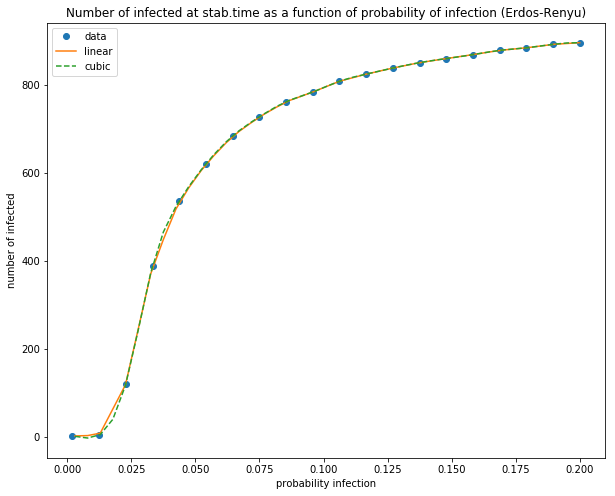

In [27]:
f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.003, 0.2, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection (Erdos-Renyu)')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [596]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

In [597]:
std_at_stab_time

[6.629479617586889,
 13.294570320247287,
 14.687409574189726,
 9.088432208032362,
 10.328910881598313,
 10.695793565696752,
 8.690224392960172,
 9.663519027766231,
 9.956786630233672,
 9.379637519648613,
 9.897292559078974,
 9.314311568763417,
 9.63034786495275,
 9.301075206662937,
 9.691315700151344,
 9.145578166523974,
 10.543244282477762,
 11.01044958210154,
 8.788629017087933,
 10.0672935787132]

Text(0,0.5,'% of infected')

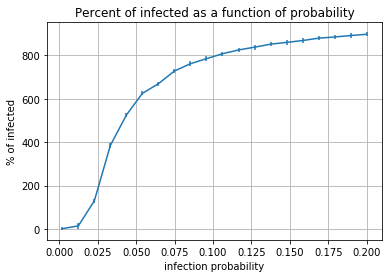

In [19]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('% of infected')

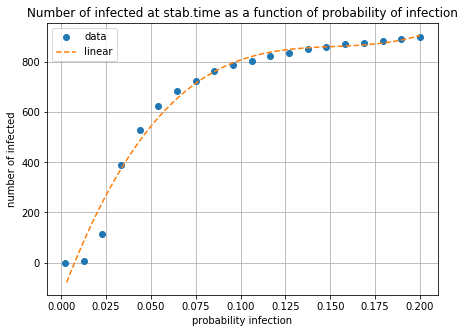

In [599]:
z = np.polyfit(p_inf_arr, frac_arr, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, frac_arr, 3))
f1 = interp1d(p_inf_arr, frac_arr, kind='cubic')
xp = np.linspace(0.003, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, frac_arr, 'o', xp, p30(xp), '--')#, xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.grid(True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.show()

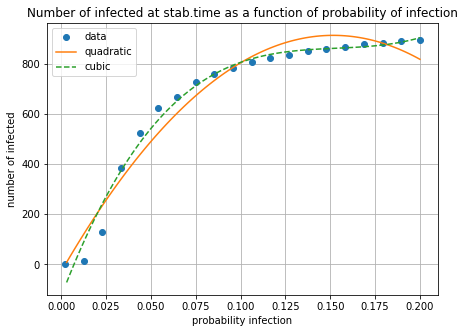

In [22]:
z = np.polyfit(p_inf_arr, frac_arr, 2)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, frac_arr, 3))
f1 = interp1d(p_inf_arr, frac_arr, kind='cubic')
xp = np.linspace(0.003, 0.2, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, frac_arr, 'o', xp, p(xp), '-', xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.legend(['data', 'quadratic', 'cubic'], loc='best')
plt.grid(True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.show()

## Adjacency matrix and eigenvalue

In [304]:
G = nx.erdos_renyi_graph(5000, 0.05)
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [305]:
max_eigval

251.59488749626894

Epidemic threshold $\tau = \frac{1}{251} = 0.0039$

In [62]:
tau_arr = np.linspace(0.0001, 0.01, 10)
tau_arr

array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ])

In [307]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

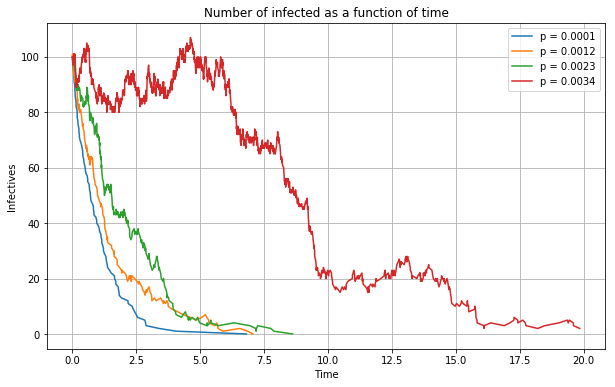

In [308]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label='p = 0.0001')

ax.plot(t_arr[1], I_arr[1], label='p = 0.0012')

ax.plot(t_arr[2], I_arr[2], label='p = 0.0023')

ax.plot(t_arr[3], I_arr[3], label='p = 0.0034')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

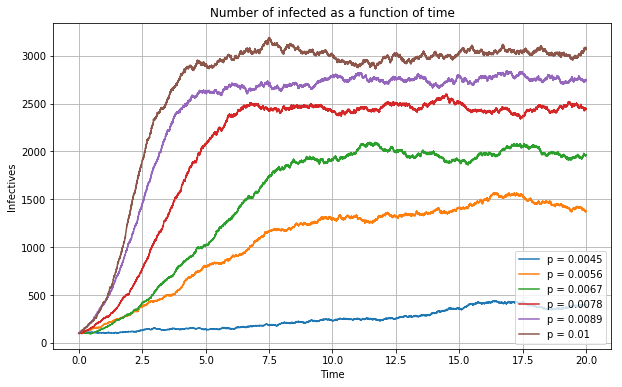

In [309]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label='p = 0.0045')

ax.plot(t_arr[5], I_arr[5], label='p = 0.0056')

ax.plot(t_arr[6], I_arr[6], label='p = 0.0067')

ax.plot(t_arr[7], I_arr[7], label='p = 0.0078')

ax.plot(t_arr[8], I_arr[8], label='p = 0.0089')

ax.plot(t_arr[9], I_arr[9], label='p = 0.01')

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()


## Exponential decay:
Если epidemic threshold $\tau < \tau_c$, то число зараженных убывает экспоненциально

In [63]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for G in G_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

In [94]:
len(t_arr[0])

103

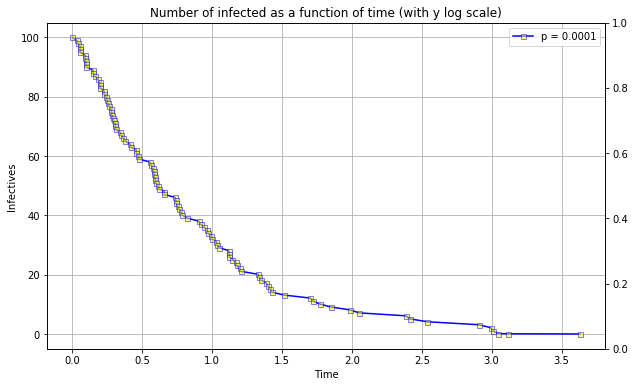

In [128]:
fig, ax = plt.subplots(figsize=(10, 6))

#ax.set_yscale('log')

z = np.polyfit(t_arr[0][10:80], I_arr[0][10:80], 1)
p = np.poly1d(z)
xp = np.linspace(0, 3, 100)

#ax.bar(t_arr[0][:95], I_arr[0][:95], label='p = 0.0001', marker = 's')
l, = ax.plot(t_arr[0], I_arr[0], label='p = 0.0001', marker = 's', markersize = 5)

l.set_markerfacecolor((1, 1, 0, 0.5))
l.set_color('blue')
#ax.scatter(t_arr[1], I_arr[1], label='p = 0.0012', marker = '^')
#
#ax.scatter(t_arr[2], I_arr[2], label='p = 0.0023', marker = 'o')
#
#ax.scatter(t_arr[3], I_arr[3], label='p = 0.0034', marker = 's')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [148]:
import numpy.polynomial.polynomial as poly

z = poly.polyfit(np.log(new_t_arr[0][1:]), np.log(new_I_arr[0][1:]), 1)
ffit = poly.polyval(np.linspace(0.01, 7, len(z)), np.log(z))

/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [168]:
new_t = np.asarray(new_t_arr[0][1:], dtype=float)
new_I = np.asarray(new_I_arr[0][1:], dtype=float)

In [169]:
log_new_I = np.log(new_I)
#log_new_I = np.log10(new_I)
log_new_t = new_t

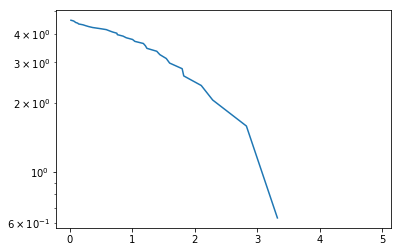

In [172]:
coefficients = poly.polyfit(log_new_t, log_new_I, 1)
polynomial = np.poly1d(coefficients)
#ys = polynomial(new_I)
plt.yscale('log')
plt.plot(log_new_t, log_new_I)
plt.show()

In [173]:
coefficients

array([ 5.1037139 , -1.56457821])

In [174]:
ffit = poly.polyval(np.linspace(0.01, 7, len(coefficients)), coefficients)

In [135]:
new_t_arr = [[],[],[],[]]
new_I_arr = [[],[],[],[]]
for i in range(4):
    for j in np.arange(0, len(t_arr[i]), 8):
        new_t_arr[i].append(t_arr[i][j])
        new_I_arr[i].append(I_arr[i][j])

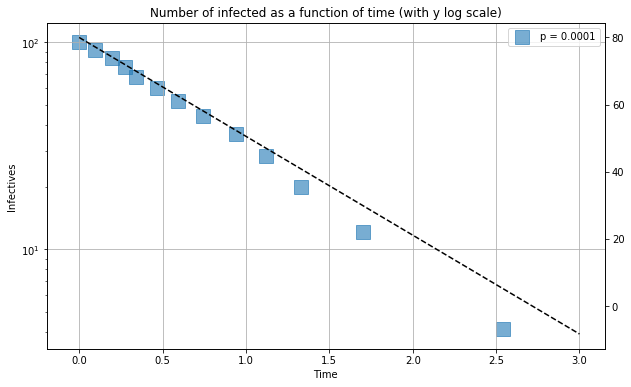

In [158]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

z = np.polyfit(new_t_arr[3], new_I_arr[3], 1)
p = np.poly1d(z)
xp = np.linspace(0, 3, 100)

axes2 = plt.twinx()
axes2.plot(xp, p(xp), '--', color='black')

ax.scatter(new_t_arr[0], new_I_arr[0], label='p = 0.0001', marker = 's', alpha = 0.6, s = 200)

#ax.scatter(new_t_arr[1], new_I_arr[1], label='p = 0.0012', marker = '^', alpha = 0.6, s = 200)

#ax.scatter(new_t_arr[2], new_I_arr[2], label='p = 0.0023', marker = 'o', alpha = 0.6, s = 200)

#ax.scatter(new_t_arr[3], new_I_arr[3], label='p = 0.0034', marker = 's', alpha = 0.6, s = 200)

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

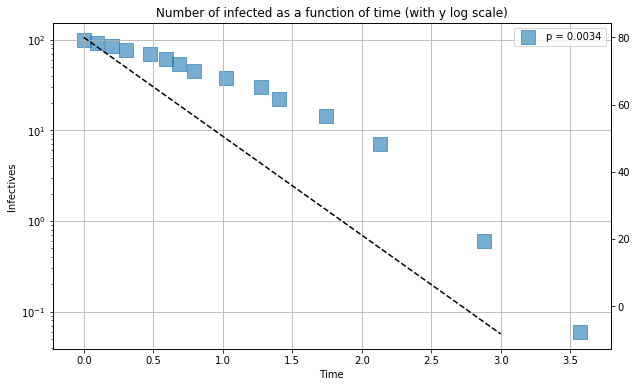

In [159]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

z = np.polyfit(new_t_arr[3], new_I_arr[3], 1)
p = np.poly1d(z)
xp = np.linspace(0, 3, 100)

axes2 = plt.twinx()
axes2.plot(xp, p(xp), '--', color='black')

#ax.scatter(new_t_arr[0], new_I_arr[0], label='p = 0.0001', marker = 's', alpha = 0.6, s = 200)

#ax.scatter(new_t_arr[1], new_I_arr[1], label='p = 0.0012', marker = '^', alpha = 0.6, s = 200)

#ax.scatter(new_t_arr[2], new_I_arr[2], label='p = 0.0023', marker = 'o', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[3], new_I_arr[3], label='p = 0.0034', marker = 's', alpha = 0.6, s = 200)

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [161]:
len(new_t_arr[0])

13

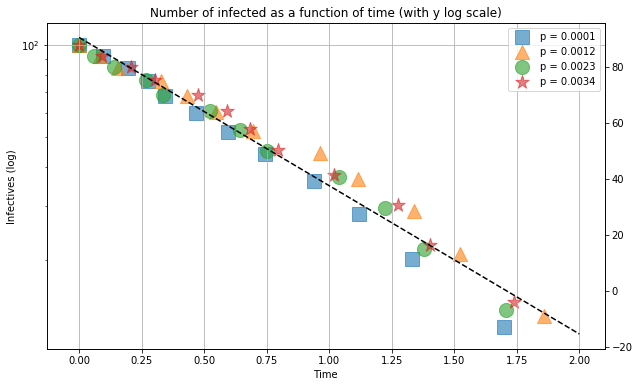

In [180]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

z = np.polyfit(new_t_arr[0][:12], new_I_arr[0][:12], 1)
p = np.poly1d(z)
xp = np.linspace(0, 2, 100)

axes2 = plt.twinx()
axes2.plot(xp, p(xp), '--', color='black')

ax.scatter(new_t_arr[0][:12], new_I_arr[0][:12], label='p = 0.0001', marker = 's', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[1][:12], new_I_arr[1][:12], label='p = 0.0012', marker = '^', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[2][:12], new_I_arr[2][:12], label='p = 0.0023', marker = 'o', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[3][:12], new_I_arr[3][:12], label='p = 0.0034', marker = '*', alpha = 0.6, s = 200)

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives (log)')
plt.show()

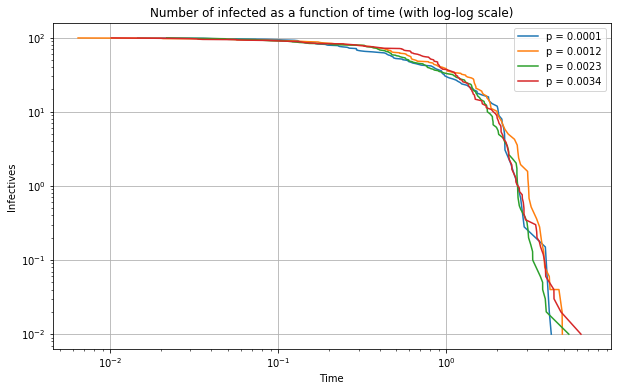

In [329]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = 0.0001')

ax.plot(t_arr[1], I_arr[1], label='p = 0.0012')

ax.plot(t_arr[2], I_arr[2], label='p = 0.0023')

ax.plot(t_arr[3], I_arr[3], label='p = 0.0034')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with log-log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

# Barabashi-Albert

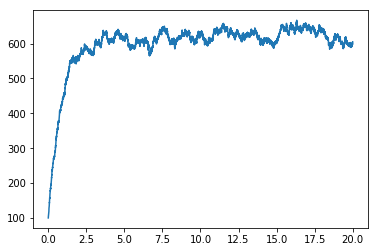

In [182]:
G = nx.barabasi_albert_graph(1000, 5)
initial_size = 100
gamma = 1.
tau = 0.3
t, S, I = SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label='p = 0.0001')

ax.plot(t_arr[1], I_arr[1], label='p = 0.0012')

ax.plot(t_arr[2], I_arr[2], label='p = 0.0023')

ax.plot(t_arr[3], I_arr[3], label='p = 0.0034')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

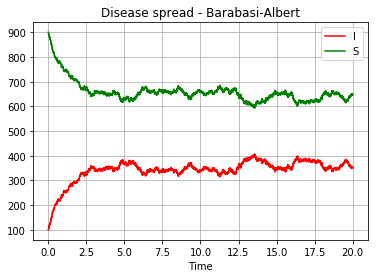

In [612]:
G = nx.barabasi_albert_graph(1000, 5)
initial_size = 100
gamma = 1.
tau = 0.15
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
fig, ax = plt.subplots()
plt.title('Disease spread - Barabasi-Albert')
ax.set_xlabel('Time')
ax.grid(True)

ax.plot(t, I, label = 'I', c = 'red')
ax.plot(t, S, label = 'S', c = 'green')
plt.legend()
plt.show()

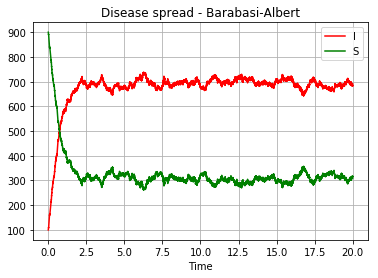

In [613]:
G = nx.barabasi_albert_graph(1000, 5)
initial_size = 100
gamma = 1.
tau = 0.4
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
fig, ax = plt.subplots()
plt.title('Disease spread - Barabasi-Albert')
ax.set_xlabel('Time')
ax.grid(True)

ax.plot(t, I, label = 'I', c = 'red')
ax.plot(t, S, label = 'S', c = 'green')
plt.legend()
plt.show()

In [601]:
network_arr = np.arange(100)
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.barabasi_albert_graph(1000, 5))

In [602]:
p_inf_arr = np.linspace(0.05, 0.5, 20)
p_inf_arr

array([0.05      , 0.07368421, 0.09736842, 0.12105263, 0.14473684,
       0.16842105, 0.19210526, 0.21578947, 0.23947368, 0.26315789,
       0.28684211, 0.31052632, 0.33421053, 0.35789474, 0.38157895,
       0.40526316, 0.42894737, 0.45263158, 0.47631579, 0.5       ])

In [603]:
initial_size = 100
gamma = 1.
t_stab = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.0736842105263158
--------------------------------
infection probability:  0.09736842105263158
--------------------------------
infection probability:  0.12105263157894737
--------------------------------
infection probability:  0.14473684210526316
--------------------------------
infection probability:  0.16842105263157897
--------------------------------
infection probability:  0.19210526315789472
--------------------------------
infection probability:  0.21578947368421053
--------------------------------
infection probability:  0.23947368421052634
--------------------------------
infection probability:  0.2631578947368421
--------------------------------
infection probability:  0.2868421052631579
--------------------------------
infection probability:  0.3105263157894737
--------------------------------
infection probability:  0.33421052631578946
------------------

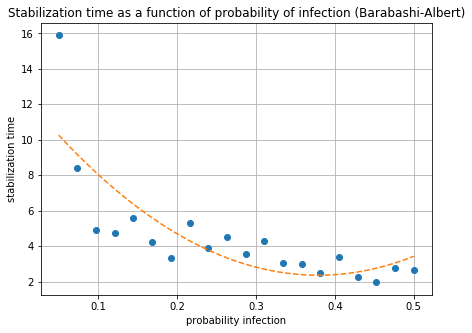

In [605]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 2))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.05, 0.5, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p30(xp), '--')#, xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.title('Stabilization time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.grid(True)
plt.show()

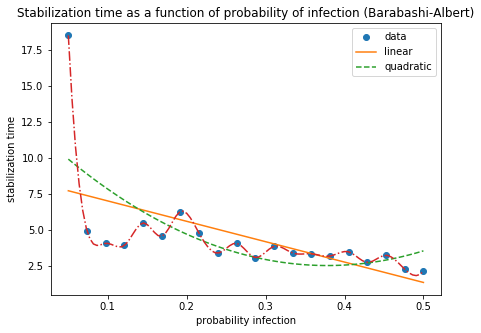

In [30]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 2))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.05, 0.5, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p(xp), '-', xp, p30(xp), '--', xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'quadratic'], loc='best')
plt.title('Stabilization time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.show()

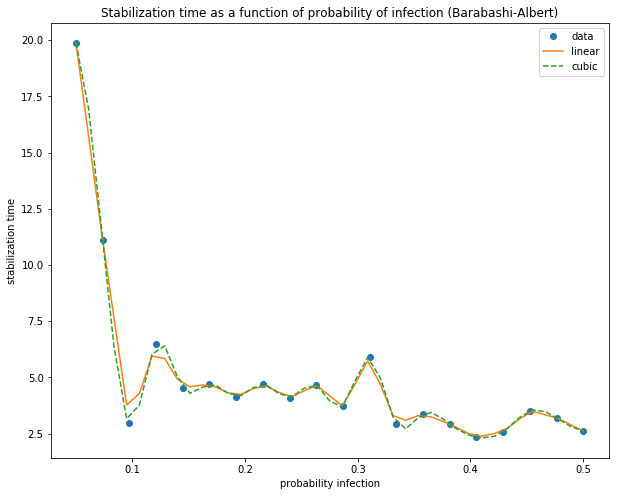

In [36]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.05, 0.5, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0.5,1,'SIS model on Barabashi-Albert network (ensemble)')

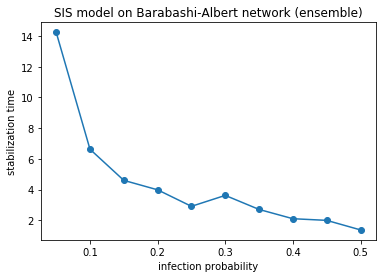

In [299]:
f = plt.figure()
plt.plot(p_inf_arr, t_stab, 'o-')
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on Barabashi-Albert network (ensemble)')

In [606]:
p_inf_arr = np.linspace(0.02, 0.4, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.04
--------------------------------
infection probability:  0.06
--------------------------------
infection probability:  0.08
--------------------------------
infection probability:  0.1
--------------------------------
infection probability:  0.12000000000000001
--------------------------------
infection probability:  0.13999999999999999
--------------------------------
infection probability:  0.16
--------------------------------
infection probability:  0.18
--------------------------------
infection probability:  0.19999999999999998
--------------------------------
infection probability:  0.22
--------------------------------
infection probability:  0.24
--------------------------------
infection probability:  0.26
--------------------------------
infection probability:  0.28
--------------------------------
infection probability:  0.30000000000000004
-----------

In [607]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

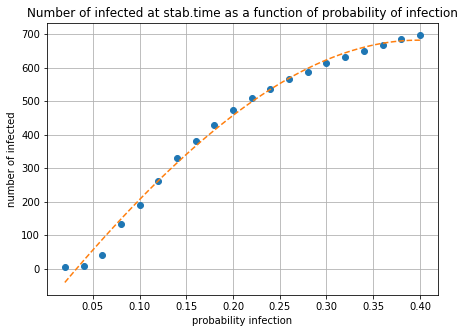

In [609]:
z = np.polyfit(p_inf_arr, frac_arr, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, frac_arr, 3))
f1 = interp1d(p_inf_arr, frac_arr, kind='cubic')
xp = np.linspace(0.02, 0.4, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, frac_arr, 'o', xp, p30(xp), '--')#, xp, p30(xp), '--')
plt.grid(True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.show()

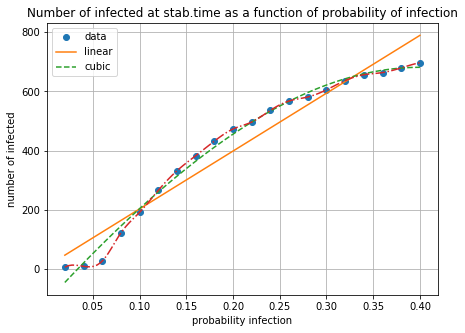

In [34]:
z = np.polyfit(p_inf_arr, frac_arr, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, frac_arr, 3))
f1 = interp1d(p_inf_arr, frac_arr, kind='cubic')
xp = np.linspace(0.02, 0.4, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, frac_arr, 'o', xp, p(xp), '-', xp, p30(xp), '--', xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.grid(True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.show()

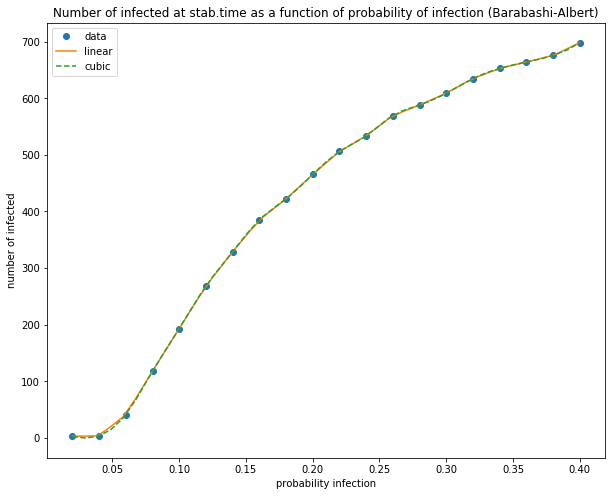

In [42]:
f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.02, 0.4, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0,0.5,'% of infected')

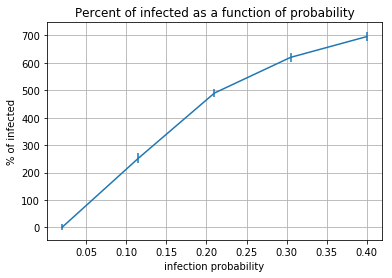

In [302]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('% of infected')

## Matrix adjacency

In [345]:
G = nx.barabasi_albert_graph(5000, 5)
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [346]:
max_eigval

25.52253059578642

In [347]:
tau = 1 / max_eigval
print("Epidemic threshold: ", tau)

Epidemic threshold:  0.039181067733349784


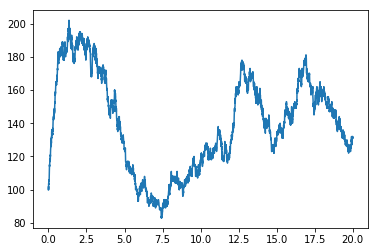

In [354]:
initial_size = 100
gamma = 1.
tau = 0.05
t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [204]:
tau_arr = np.linspace(0.01, 0.1, 10)
tau_arr

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [205]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

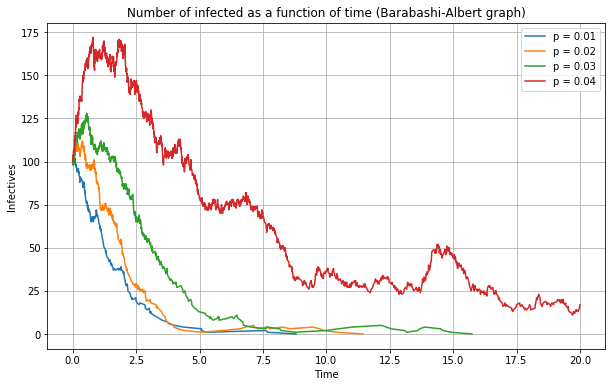

In [359]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label='p = 0.01')

ax.plot(t_arr[1], I_arr[1], label='p = 0.02')

ax.plot(t_arr[2], I_arr[2], label='p = 0.03')

ax.plot(t_arr[3], I_arr[3], label='p = 0.04')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (Barabashi-Albert graph)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

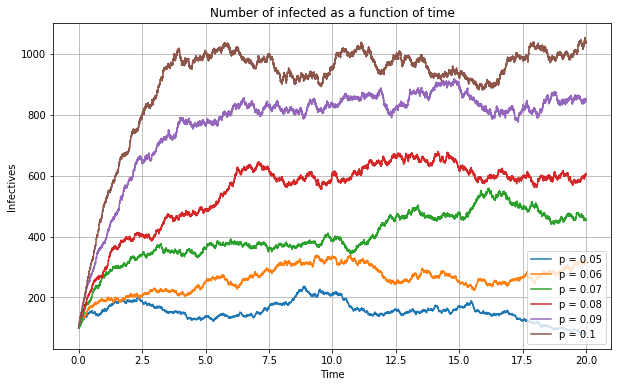

In [360]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label='p = 0.05')

ax.plot(t_arr[5], I_arr[5], label='p = 0.06')

ax.plot(t_arr[6], I_arr[6], label='p = 0.07')

ax.plot(t_arr[7], I_arr[7], label='p = 0.08')

ax.plot(t_arr[8], I_arr[8], label='p = 0.09')

ax.plot(t_arr[9], I_arr[9], label='p = 0.1')

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [203]:
network_arr = np.arange(100)
N = 5000
m = 5
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.barabasi_albert_graph(N, m))

In [362]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for G in G_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

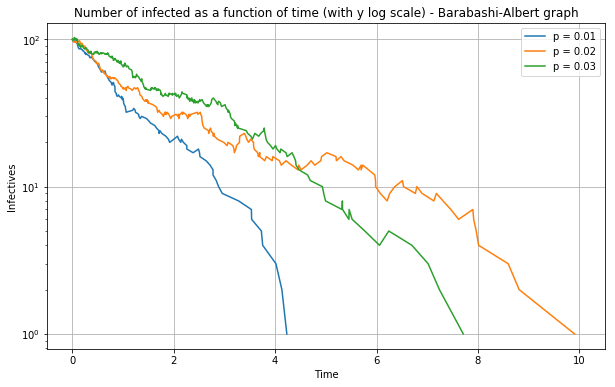

In [207]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = 0.01')

ax.plot(t_arr[1], I_arr[1], label='p = 0.02')

ax.plot(t_arr[2], I_arr[2], label='p = 0.03')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale) - Barabashi-Albert graph')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [249]:
tau_arr = np.linspace(0.001, 0.01, 4)
tau_arr

array([0.001, 0.004, 0.007, 0.01 ])

In [250]:
initial_size = 100
gamma = 1.
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

In [251]:
new_t_arr = [[],[],[],[]]
new_I_arr = [[],[],[],[]]
for i in range(4):
    for j in np.arange(0, len(t_arr[i]), 8):
        new_t_arr[i].append(t_arr[i][j])
        new_I_arr[i].append(I_arr[i][j])

In [258]:
len(new_t_arr[3])

20

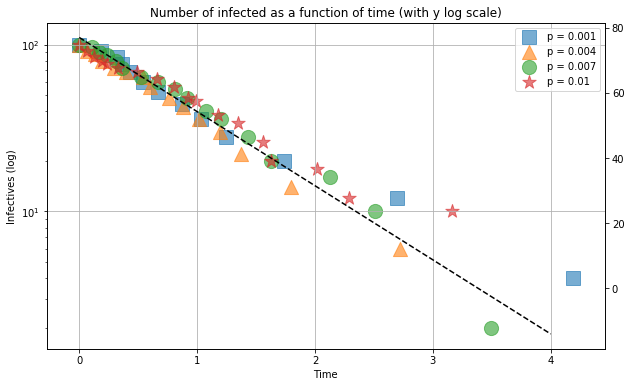

In [259]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

z1 = np.polyfit(new_t_arr[0], new_I_arr[0], 1)
p1 = np.poly1d(z1)
xp1 = np.linspace(0, 4, 100)

z2 = np.polyfit(new_t_arr[1], new_I_arr[1], 1)
p2 = np.poly1d(z2)
xp2 = np.linspace(0, 3, 100)

axes2 = plt.twinx()
axes2.plot(xp1, p1(xp1), '--', color='black')
#axes2.plot(xp2, p2(xp2), '--', color='black')


ax.scatter(new_t_arr[0], new_I_arr[0], label='p = 0.001', marker = 's', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[1], new_I_arr[1], label='p = 0.004', marker = '^', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[2], new_I_arr[2], label='p = 0.007', marker = 'o', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[3][:18], new_I_arr[3][:18], label='p = 0.01', marker = '*', alpha = 0.6, s = 200)

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives (log)')
plt.show()

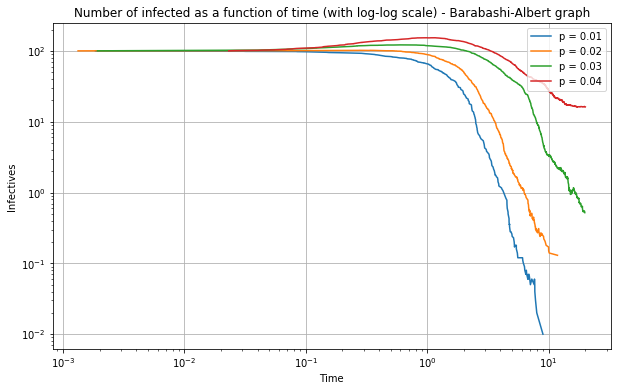

In [364]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = 0.01')

ax.plot(t_arr[1], I_arr[1], label='p = 0.02')

ax.plot(t_arr[2], I_arr[2], label='p = 0.03')

ax.plot(t_arr[3], I_arr[3], label='p = 0.04')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with log-log scale) - Barabashi-Albert graph')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

# Random Regular Graph

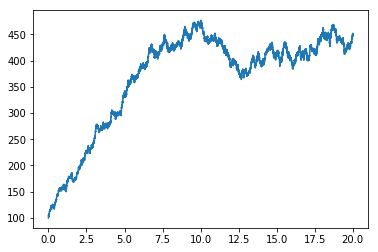

In [11]:
G = nx.random_regular_graph(5, 1000)
initial_size = 100
gamma = 1.
tau = 0.4
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))

plt.plot(t, I)

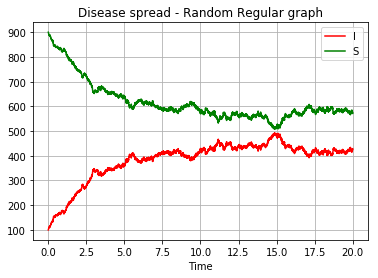

In [614]:
G = nx.random_regular_graph(5, 1000)
initial_size = 100
gamma = 1.
tau = 0.4
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
fig, ax = plt.subplots()
plt.title('Disease spread - Random Regular graph')
ax.set_xlabel('Time')
ax.grid(True)

ax.plot(t, I, label = 'I', c = 'red')
ax.plot(t, S, label = 'S', c = 'green')
plt.legend()
plt.show()

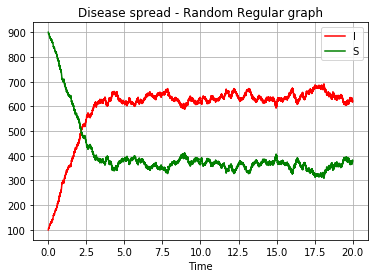

In [615]:
G = nx.random_regular_graph(5, 1000)
initial_size = 100
gamma = 1.
tau = 0.6
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
fig, ax = plt.subplots()
plt.title('Disease spread - Random Regular graph')
ax.set_xlabel('Time')
ax.grid(True)

ax.plot(t, I, label = 'I', c = 'red')
ax.plot(t, S, label = 'S', c = 'green')
plt.legend()
plt.show()

In [616]:
network_arr = np.arange(100)
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.random_regular_graph(5, 1000))

In [617]:
p_inf_arr = np.linspace(0.05, 0.5, 20)
p_inf_arr

array([0.05      , 0.07368421, 0.09736842, 0.12105263, 0.14473684,
       0.16842105, 0.19210526, 0.21578947, 0.23947368, 0.26315789,
       0.28684211, 0.31052632, 0.33421053, 0.35789474, 0.38157895,
       0.40526316, 0.42894737, 0.45263158, 0.47631579, 0.5       ])

In [618]:
initial_size = 100
gamma = 1.
t_stab = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.0736842105263158
--------------------------------
infection probability:  0.09736842105263158
--------------------------------
infection probability:  0.12105263157894737
--------------------------------
infection probability:  0.14473684210526316
--------------------------------
infection probability:  0.16842105263157897
--------------------------------
infection probability:  0.19210526315789472
--------------------------------
infection probability:  0.21578947368421053
--------------------------------
infection probability:  0.23947368421052634
--------------------------------
infection probability:  0.2631578947368421
--------------------------------
infection probability:  0.2868421052631579
--------------------------------
infection probability:  0.3105263157894737
--------------------------------
infection probability:  0.33421052631578946
------------------

In [619]:
t_stab

[5.837185637963573,
 6.468049180911931,
 6.021923825858358,
 7.955982585620276,
 13.901243204268187,
 17.98020502893944,
 19.923509732159605,
 19.880582120103412,
 19.995956960574834,
 4.9182543313551434,
 7.721960245600978,
 4.556946372791286,
 10.276364651180899,
 10.333396382923977,
 6.712463760732824,
 8.65458399743649,
 6.85944406105003,
 8.620839042463315,
 5.840091668462173,
 5.785054784606334]

In [621]:
del t_stab[9]
del t_stab[10]
t_stab.insert(9, 16.2839198790110629)
t_stab.insert(11, 14.29558504028177)

In [277]:
len(t_stab)

20

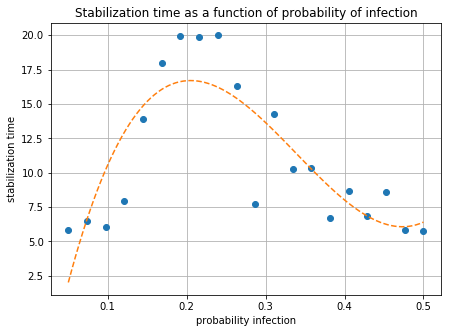

In [624]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 3))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.05, 0.5, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p30(xp), '--')#, xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.grid(True)
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.show()

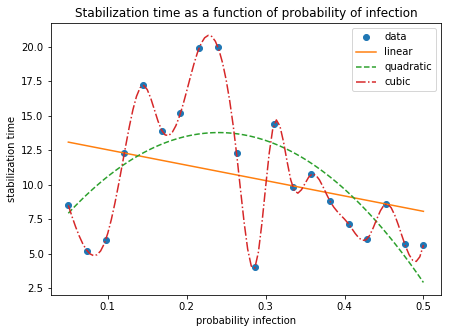

In [41]:
z = np.polyfit(p_inf_arr, t_stab, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, t_stab, 2))
f1 = interp1d(p_inf_arr, t_stab, kind='cubic')
xp = np.linspace(0.05, 0.5, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, t_stab, 'o', xp, p(xp), '-', xp, p30(xp), '--', xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'quadratic', 'cubic'], loc='best')
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.show()

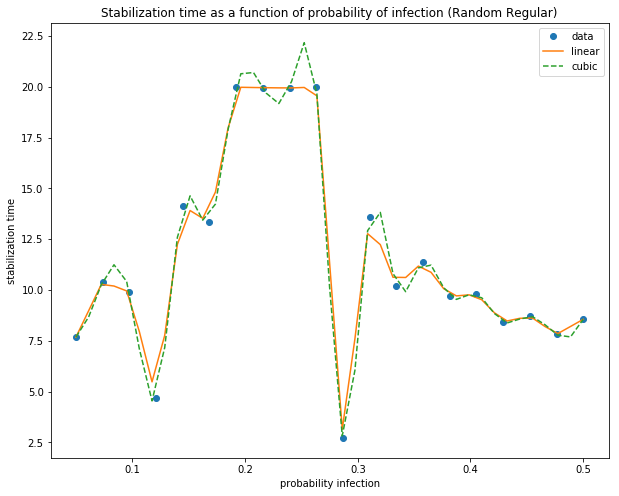

In [46]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.05, 0.5, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection (Random Regular)')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0.5,1,'SIS model on Random regular graph network (ensemble)')

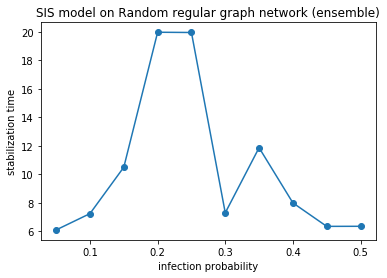

In [17]:
f = plt.figure()
plt.plot(p_inf_arr, t_stab, 'o-')
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on Random regular graph network (ensemble)')

In [625]:
p_inf_arr = np.linspace(0.02, 0.5, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.04526315789473684
--------------------------------
infection probability:  0.07052631578947369
--------------------------------
infection probability:  0.09578947368421052
--------------------------------
infection probability:  0.12105263157894737
--------------------------------
infection probability:  0.1463157894736842
--------------------------------
infection probability:  0.17157894736842103
--------------------------------
infection probability:  0.19684210526315787
--------------------------------
infection probability:  0.22210526315789472
--------------------------------
infection probability:  0.24736842105263157
--------------------------------
infection probability:  0.27263157894736845
--------------------------------
infection probability:  0.29789473684210527
--------------------------------
infection probability:  0.3231578947368421
----------------

In [43]:
for i in inf_frac:
    print(len(i))

147
201
269
373
479
608
915
1419
2445
3587
5409
8081
10204
12385
14156
16208
17473
18813
20006
21205


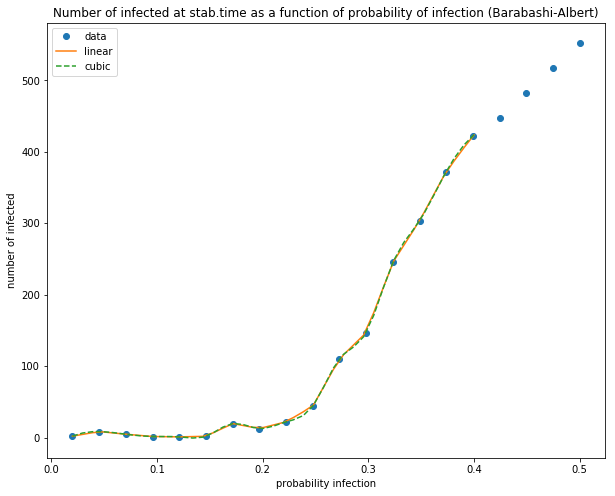

In [44]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.02, 0.4, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

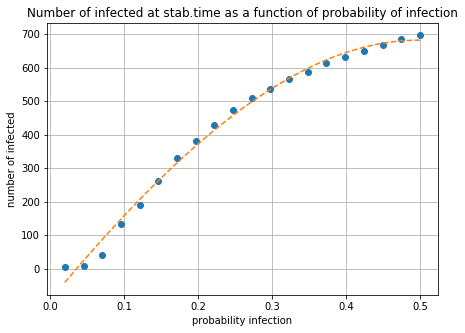

In [627]:
z = np.polyfit(p_inf_arr, frac_arr, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, frac_arr, 3))
f1 = interp1d(p_inf_arr, frac_arr, kind='cubic')
xp = np.linspace(0.02, 0.5, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, frac_arr, 'o', xp, p30(xp), '--')
plt.grid(True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.show()

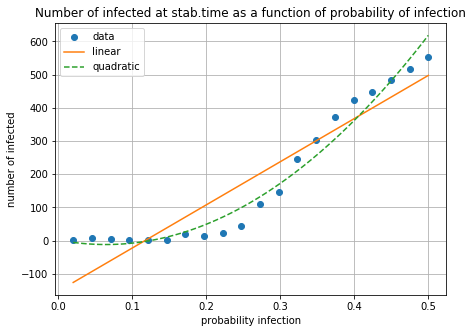

In [49]:
z = np.polyfit(p_inf_arr, frac_arr, 1)
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(p_inf_arr, frac_arr, 2))
f1 = interp1d(p_inf_arr, frac_arr, kind='cubic')
xp = np.linspace(0.02, 0.5, 100)

f = plt.figure(figsize=(7,5))
plt.plot(p_inf_arr, frac_arr, 'o', xp, p(xp), '-', xp, p30(xp), '--')#, xp, f1(xp), '-.')
plt.legend(['data', 'linear', 'quadratic'], loc='best')
plt.grid(True)
plt.title('Number of infected at stab.time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.show()

In [176]:
G = nx.random_regular_graph(5, 1000)
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [177]:
max_eigval

5.000000000000006

In [178]:
1 / max_eigval

0.19999999999999976

In [281]:
tau_arr = np.linspace(0.1, 0.4, 10)
tau_arr

array([0.1       , 0.13333333, 0.16666667, 0.2       , 0.23333333,
       0.26666667, 0.3       , 0.33333333, 0.36666667, 0.4       ])

In [282]:
initial_size = 100
gamma = 1.
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

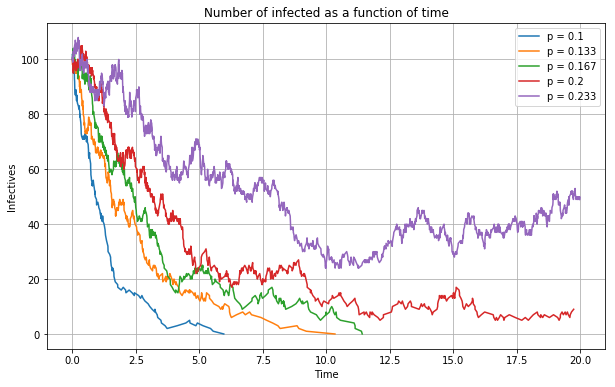

In [283]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

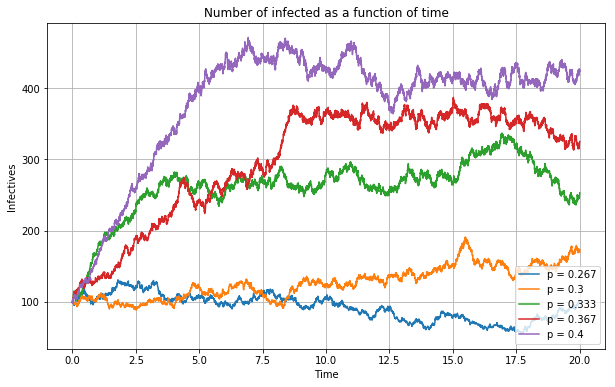

In [284]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [188]:
network_arr = np.arange(100)
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.random_regular_graph(5, 1000))

In [190]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for G in G_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

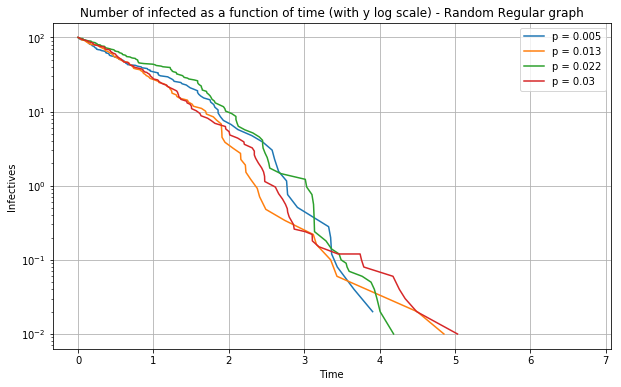

In [192]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale) - Random Regular graph')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [285]:
new_t_arr = [[],[],[],[]]
new_I_arr = [[],[],[],[]]
for i in range(4):
    for j in np.arange(0, len(t_arr[i]), 8):
        new_t_arr[i].append(t_arr[i][j])
        new_I_arr[i].append(I_arr[i][j])

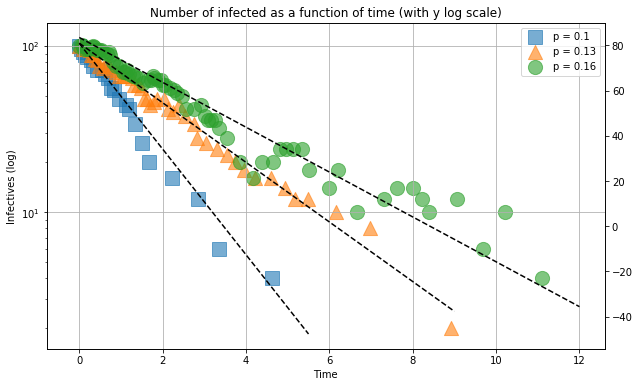

In [294]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

z1 = np.polyfit(new_t_arr[0], new_I_arr[0], 1)
p1 = np.poly1d(z1)
xp1 = np.linspace(0, 5.5, 100)

z2 = np.polyfit(new_t_arr[1], new_I_arr[1], 1)
p2 = np.poly1d(z2)
xp2 = np.linspace(0, 9, 100)

z3 = np.polyfit(new_t_arr[2], new_I_arr[2], 1)
p3 = np.poly1d(z3)
xp3 = np.linspace(0, 12, 100)

axes2 = plt.twinx()
axes2.plot(xp1, p1(xp1), '--', color='black')
axes2.plot(xp2, p2(xp2), '--', color='black')
axes2.plot(xp3, p3(xp3), '--', color='black')


ax.scatter(new_t_arr[0], new_I_arr[0], label='p = 0.1', marker = 's', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[1], new_I_arr[1], label='p = 0.13', marker = '^', alpha = 0.6, s = 200)

ax.scatter(new_t_arr[2], new_I_arr[2], label='p = 0.16', marker = 'o', alpha = 0.6, s = 200)

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives (log)')
plt.show()